In [140]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from pywaffle import Waffle

def load_csv(file_name):
    """Loads a CSV file into a Pandas DataFrame"""
    df = pd.read_csv(file_name,low_memory=False)
    return df

# Load the data
file_name = './kaggle_survey_2020_responses.csv'
survey_df = load_csv(file_name)

# Preview the data
responses_df = survey_df[1:]
survey_df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor..."
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
questions = survey_df.iloc[0]

In [3]:
questions

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                           What is your age (# years)?
Q2                                                What is your gender? - Selected Choice
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
                                                             ...                        
Q35_B_Part_7                           In the next 2 years, do you hope to become mor...
Q35_B_Part_8                           In the next 2 years, do you hope to become mor...
Q35_B_Part_9                           In the next 2 years, do you hope to become mor...
Q35_B_Part_10                          In the next 2 years, do you hope to become mor...
Q35_B_OTHER                            In the next 2 years, do you hope to become mor...
Name: 0, Length: 355,

In [4]:
responses_df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature engineering

In [5]:
# student subset
student_df = responses_df[responses_df['Q5'] == 'Student']

# data related jobs
data_df = responses_df[responses_df['Q5'] == 'Data Scientist']

In [6]:
# helper function to create look up tables for multiple choice questions
def df_to_count(q, df):
    ret = {}
    keys = []
    counts = []
    cat = q + "_Part_"
    other = q + "_OTHER"
    for i in range(1, 20):
        temp = cat + str(i)
        key = ""
        
        # out of bound
        if temp not in df.columns:
            break
        
        # find key
        df_na = df.notna()
        for j in range(df.shape[0]):
            if df_na.iloc[j][temp]:
                key = df.iloc[j][temp]
                break
                
        # count the number of items for such key
        keys.append(key)
        counts.append(df[temp].count())
        temp = ""
    
    # handle other column
    if other in df.columns:
        counts.append(df[other].count())
        keys.append("other")
    ret["key"] = keys
    ret["count"] = counts
    # sort the dict
    #ret = {k:v for k, v in sorted(ret.items(), key = lambda item:item[1], reverse = True)}
    return ret

In [7]:
df_to_count("Q7", student_df)

{'key': ['Python',
  'R',
  'SQL',
  'C',
  'C++',
  'Java',
  'Javascript',
  'Julia',
  'Swift',
  'Bash',
  'MATLAB',
  'None',
  'other'],
 'count': [4341, 914, 1408, 1480, 1632, 1148, 725, 62, 40, 229, 749, 44, 244]}

# EDA

## 1. Gender

In [8]:
Q1 = responses_df.groupby("Q2", as_index = False).count().sort_values(by = ['Q3'], ascending = False, ignore_index = True)
Q1.iloc[0]['Q3']

15789

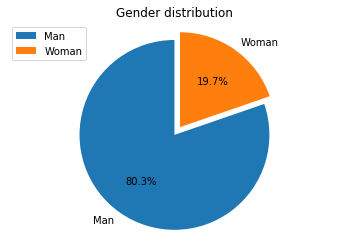

In [9]:
# distribution of gender; pie
labels = Q1.iloc[0]['Q2'], Q1.iloc[1]['Q2']
sizes = [Q1.iloc[0]['Q3'], Q1.iloc[1]['Q3']]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Gender distribution')
plt.legend()

plt.show()

In [66]:
fig = px.pie(Q1, values='Q3', names='Q2', title='Gender distribution')
fig.show()

In [83]:
# distribution of gender; bar
Q1 = responses_df.groupby("Q2", as_index = False).count().sort_values(by = ['Q3'], ascending = False, ignore_index = True)
ch = alt.Chart(Q1).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('Q2', sort = '-y', title = "Gender"),
    y = alt.Y('Q3', title = "Count")
)

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'Q3')
(ch+text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

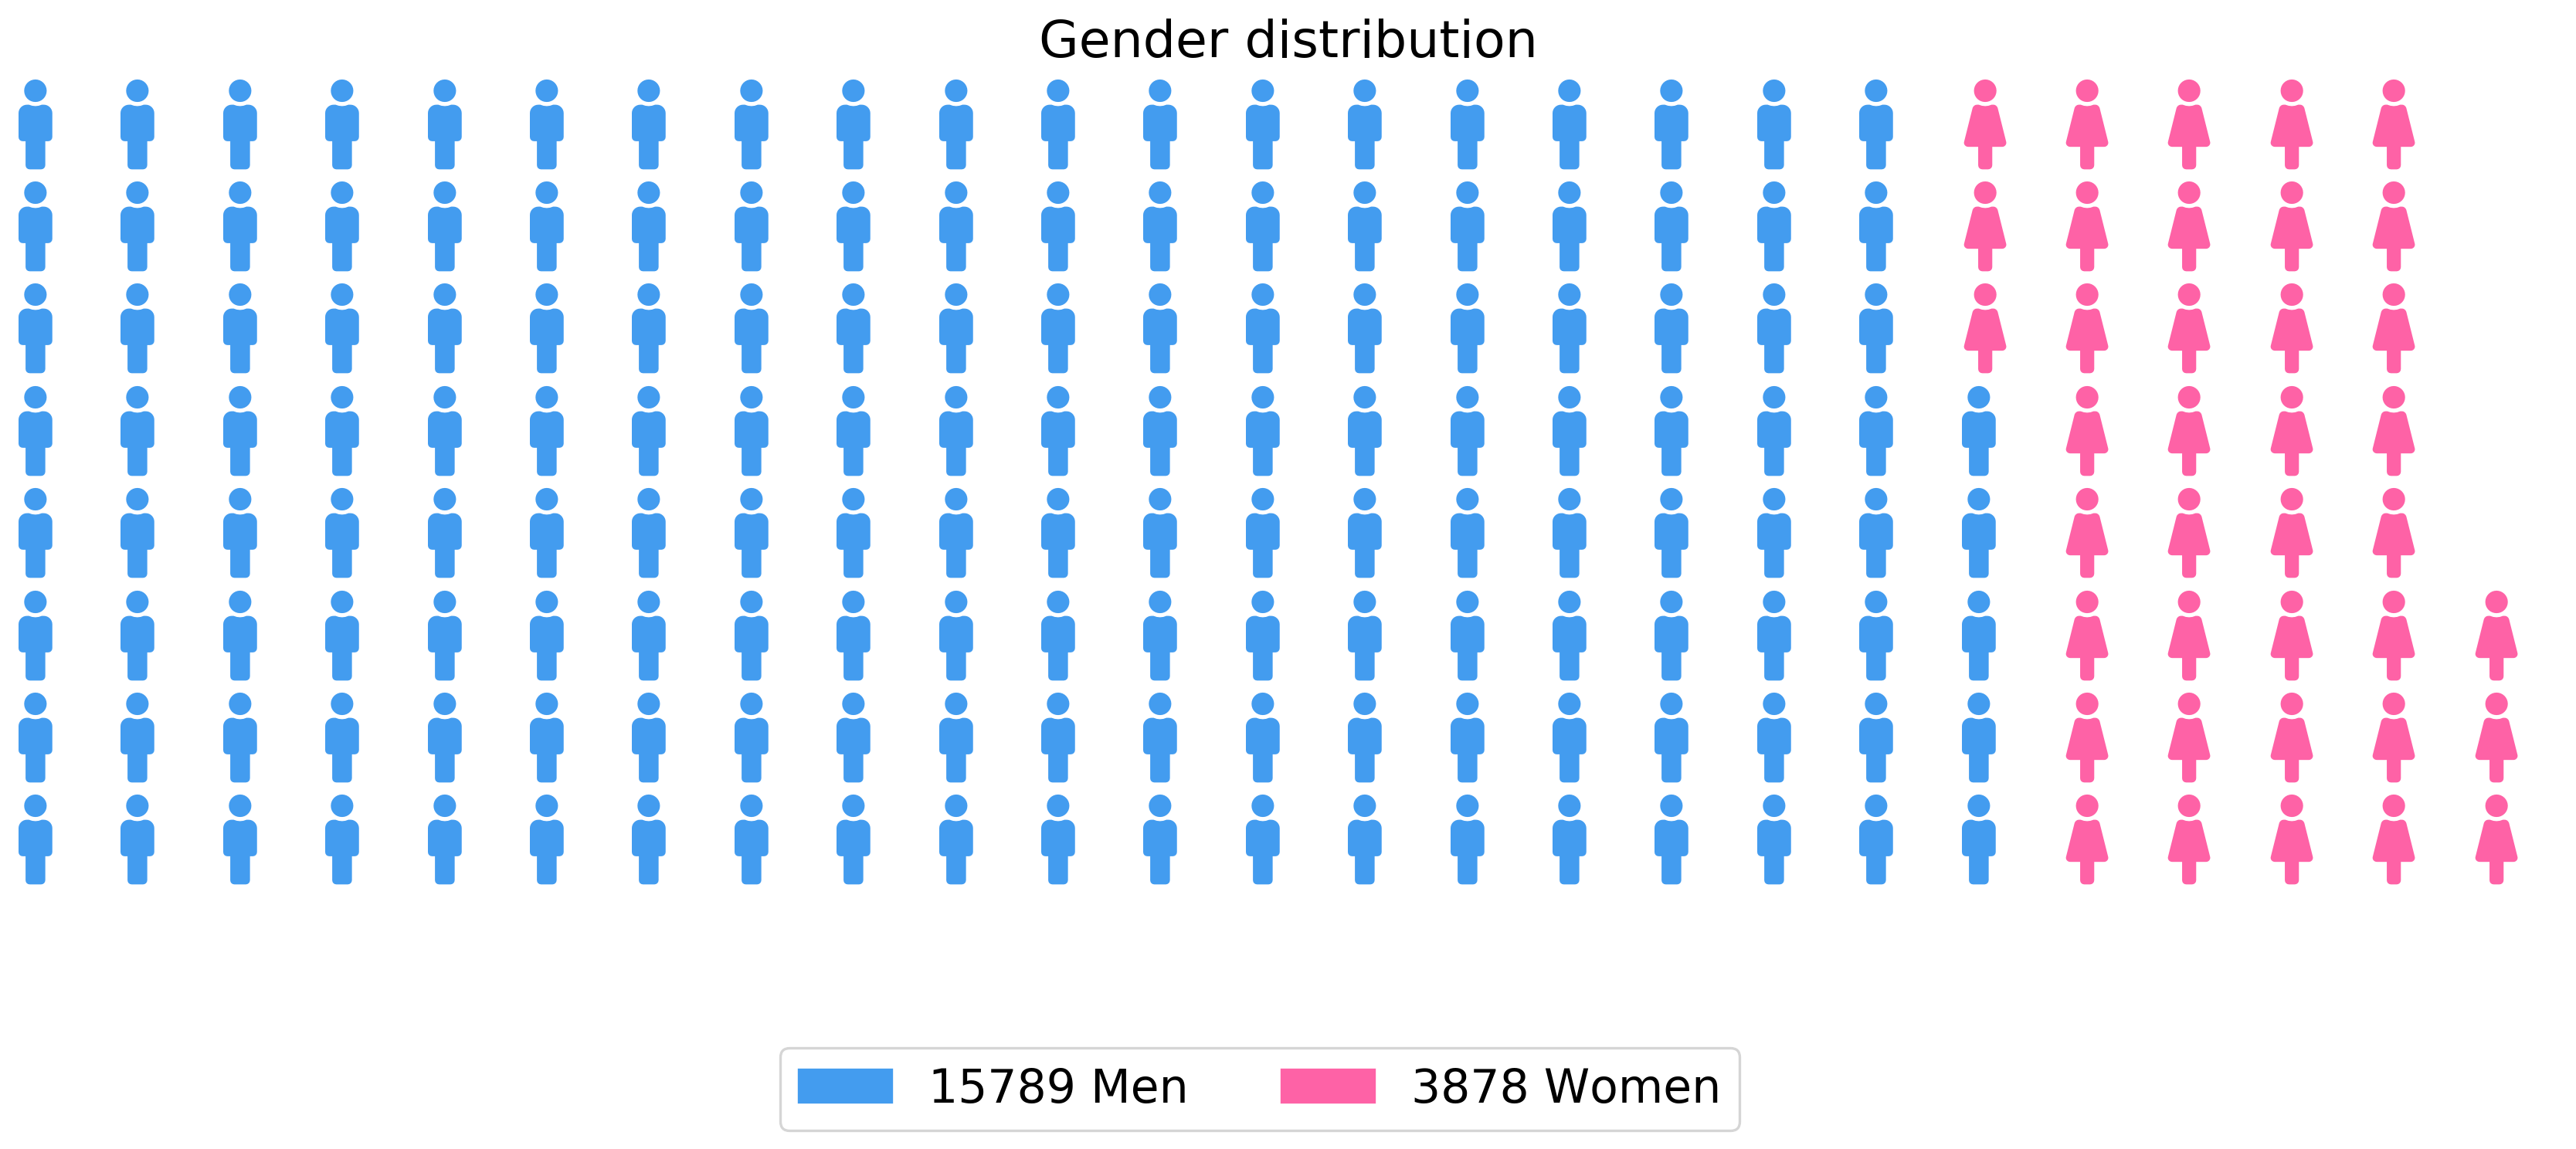

In [118]:
df_men = responses_df[responses_df.Q2 == "Man"]
df_women = responses_df[responses_df.Q2 == "Woman"]
df_men_women = pd.concat([df_men, df_women])
fig = plt.figure(
    FigureClass = Waffle,
    plots={
        '111': {
            'values': [df_men.shape[0] // 100, df_women.shape[0] // 100],
            'labels': ["{1} {0}".format(n[2], n[1]) for n in [[0, df_men.shape[0], 'Men'], [0, df_women.shape[0], 'Women']]],
            'legend': {'loc': 'center left', 'bbox_to_anchor': (0.3, -0.18, 0.6, -0.18), 'fontsize': 18,
                       "ncol":2, "borderaxespad":0.},
            'title': {'label': 'Gender distribution', 'loc': 'center', 'fontsize':20},
            'icons': ['male', 'female'], 
            'font_size' : 35,
        },
    },
    rows=8,
    colors=['#439CEF', '#FE62A6'],
    figsize=(14, 8),
    dpi = 240,
)

## 2. Age

In [82]:
# distribution of age
# distribution of gender; bar
Q2 = responses_df.groupby("Q1", as_index = False).count().sort_values(by = ['Q3'], ascending = False, ignore_index = True)
ch = alt.Chart(Q2).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('Q1', sort = '-y', title = "Age"),
    y = alt.Y('Q3', title = 'Count')
)

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'Q3')
(ch+text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

In [64]:
fig = px.pie(Q2, values='Q2', names='Q1', title='Age distribution')
fig.show()

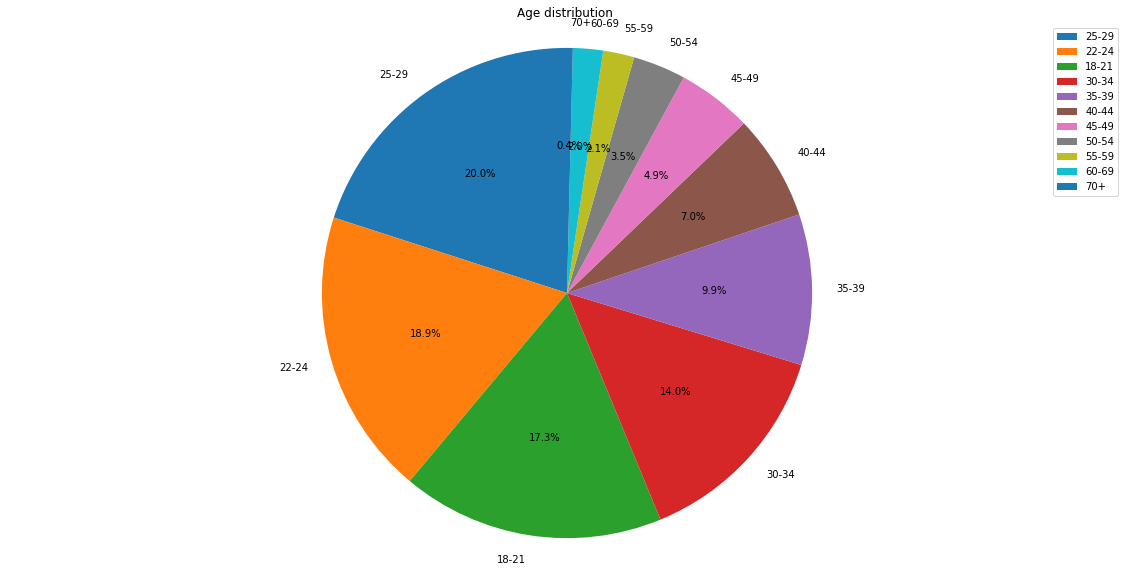

In [13]:
# pie
labels = []
sizes = []
for i in range(Q2.shape[0]):
    labels.append(Q2.iloc[i]['Q1'])
    sizes.append(Q2.iloc[i]['Q3'])
# explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (20,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Age distribution')
plt.legend()

plt.show()

## 3. Job

In [14]:
# distribution of current job; bar
Q3 = responses_df.groupby("Q5", as_index = False).count().sort_values(by = ['Q3'], ascending = False, ignore_index = True)
ch = alt.Chart(Q3).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('Q5', sort = '-y'),
    y = 'Q3'
)  

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'Q3')
(ch + text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

In [61]:
fig = px.pie(Q3, values='Q1', names='Q5', title='Job distribution')
fig.show()

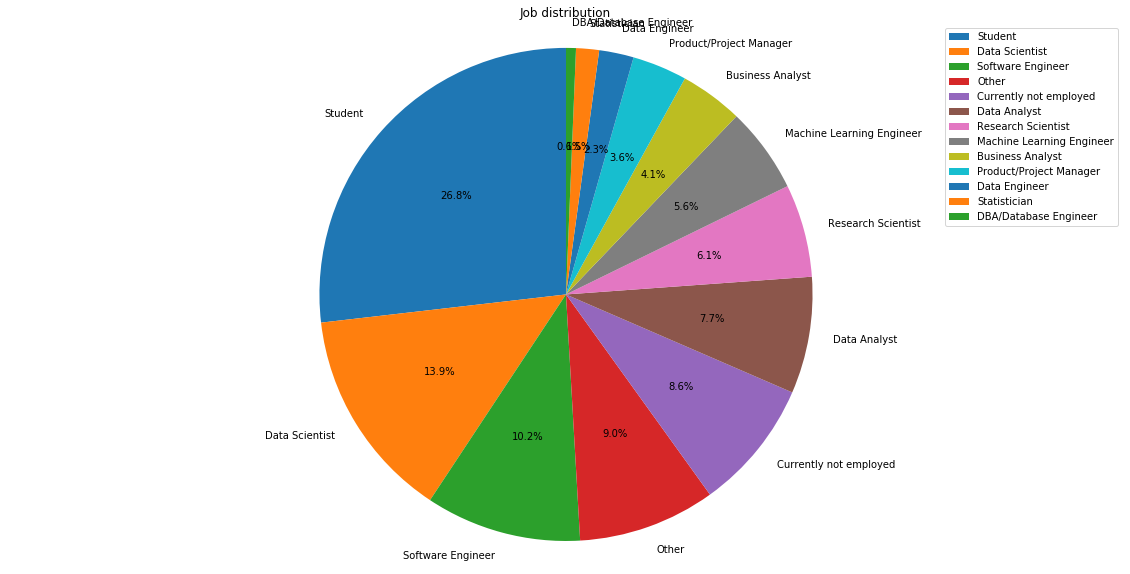

In [58]:
# pie
# pie
labels = []
sizes = []
for i in range(Q3.shape[0]):
    labels.append(Q3.iloc[i]['Q5'])
    sizes.append(Q3.iloc[i]['Q3'])
# explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (20,10))
ax1.pie(sizes, labels = labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Job distribution')
plt.legend()

plt.show()

#### 3.2 Job degree

In [16]:
education = responses_df.loc[:,['Q1','Q2','Q3','Q4','Q5']].dropna()
education_role = education.groupby(['Q5','Q4']).size().reset_index(name="Count")

total = education_role.groupby('Q5').Count.sum().reset_index(name="Total")

education_role = education_role.join(total.set_index('Q5'), on='Q5')

education_role['Percent'] = education_role.Count/education_role.Total

In [80]:
alt.Chart(education_role).mark_circle().encode(
    x = alt.X('Q4',title = 'Education level', sort = '-size'),
    y = alt.Y('Q5',title = 'Job'),
    size='Percent:Q',
    tooltip = ['Q4', 'Percent']
).interactive().properties(
    width=500,
    height=300
)

alt.Chart(...)

In [81]:
base = alt.Chart(education_role).mark_rect().encode(
    x = alt.X('Q4', title = 'Education level'),
    y = alt.Y('Q5', title = 'Job'),
    color = alt.Color('sum(Count)', title = 'Count')
).properties(
    width=300,
    height=300
)

base

alt.Chart(...)

In [20]:
alt.Chart(education_role).mark_bar().encode(
    x = alt.X('Q5', title = 'Education level'),
    y = alt.Y('Percent', title = 'Percentage'),
    color = alt.Color('Q4', title = 'Job')
)

alt.Chart(...)

# 4. Earning

In [21]:
q24_order = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999',
'10,000-14,999','15,000-19,999', '20,000-24,999', '25,000-29,999', '30,000-39,999', '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', '90,000-99,999',
'100,000-124,999', '125,000-149,999',  '150,000-199,999', '200,000-249,999',  '250,000-299,999', '300,000-500,000', '> $500,000']
Q4 = responses_df['Q24'].value_counts()[q24_order].to_frame()
Q4["earning"] = q24_order

In [22]:
# earning comparison
# Q4 = responses_df.groupby("Q24", as_index = False).count()
ch = alt.Chart(Q4).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X(field='earning', type='nominal',
        sort=q24_order, title='Earning'),
    y = alt.Y('Q24', title = 'Number of respondents')
)

text = ch.mark_text(
    align = "center",
    dy = -5,
    baseline = 'bottom'
).encode(text = 'Q24')

line = ch.mark_trail().encode(
    y="Q24"
)

(ch + text).properties(
    width=800,
    height=300
)

alt.LayerChart(...)

### 4.1 Earning Gender

In [23]:
earning = responses_df.loc[:,['Q1','Q2','Q3','Q4','Q5', 'Q24']].dropna()
earning_gender = earning.groupby(['Q2','Q24']).size().reset_index(name="Count")
index_names = earning_gender[((earning_gender['Q2'] == 'Nonbinary') | (earning_gender['Q2'] == 'Prefer not to say') | (earning_gender['Q2'] == 'Prefer to self-describe'))].index
filtered = earning_gender.drop(index_names, inplace = False)

In [24]:
alt.Chart(filtered).mark_bar(opacity=0.7).encode(
    x = alt.X('Q24', title = 'Earning'),
    y=alt.Y('Count', stack=None),
    color = alt.Color("Q2", title = 'Gender')
)

alt.Chart(...)

### 4.2 Earning Job

In [25]:
earning_job = earning.groupby(['Q5','Q24']).size().reset_index(name="Count")
index_names = earning_job[(earning_job['Q24'] == '$0-999') | (earning_job['Q5'] == 'DBA/Database Engineer') | (earning_job['Q5'] == 'Statistician') | (earning_job['Q5'] == 'Other') | (earning_job['Q5'] == 'Product/Project Manager')].index
earning_job.drop(index_names, inplace = True)

total = earning_job.groupby('Q5').Count.sum().reset_index(name="Total")


earning_job = earning_job.join(total.set_index('Q5'), on='Q5')

earning_job['Percent'] = earning_job.Count/earning_job.Total

In [26]:
total

,Q5,Total
0,Business Analyst,564
1,Data Analyst,959
2,Data Engineer,326
3,Data Scientist,1951
4,Machine Learning Engineer,645
5,Research Scientist,829
6,Software Engineer,1301


In [27]:
alt.Chart(earning_job).mark_circle().encode(
    x = alt.X('Q24',title = 'Earning',sort=q24_order),
    y = alt.Y('Q5',title = 'Job'),
    size='Percent:Q',
    tooltip = ['Q5', 'Percent']
).interactive().properties(
    width=500,
    height=300
)

alt.Chart(...)

In [28]:
alt.Chart(earning_job).mark_bar().encode(
    x = alt.X('Q24', title = 'Earning', sort=q24_order),
    y = alt.Y('Percent', title = 'Percentage'),
    color = alt.Color('Q5', title = 'Degree')
)

alt.Chart(...)

### 4.3 Earning Degree

In [29]:
q4_order = [
    'No formal education past high school',
    'Professional degree',
    'Some college/university study without earning a bachelor’s degree',
    'Bachelor’s degree',
    'Master’s degree',
    'Doctoral degree',
    'I prefer not to answer'
]
Q4_degree = responses_df['Q4'].value_counts()[q4_order].to_frame()
Q4_degree["degree"] = q4_order

In [67]:
ch = alt.Chart(Q4_degree).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X(field='degree', type='nominal',
          sort=q4_order, title = "Education level"),
    y = alt.Y('Q4', title = 'Count')
)

text = ch.mark_text(
    align = "center",
    dy = -5,
    baseline = 'bottom'
).encode(text = 'Q4')

line = ch.mark_trail().encode(
    y="Q4"
)

(ch + text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

In [31]:
responses_df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
earning_role = earning.groupby(['Q4','Q24']).size().reset_index(name="Count")
index_names = earning_role[(earning_role['Q24'] == '$0-999')].index
earning_role.drop(index_names, inplace = True)

total = earning_role.groupby('Q4').Count.sum().reset_index(name="Total")


earning_role = earning_role.join(total.set_index('Q4'), on='Q4')

earning_role['Percent'] = earning_role.Count/earning_role.Total

In [68]:
alt.Chart(earning_role).mark_circle().encode(
    x = alt.X('Q24',title = 'Earning',sort=q24_order),
    y = alt.Y('Q4',title = 'Education level'),
    size='Percent:Q',
    tooltip = ['Q4', 'Percent']
).interactive().properties(
    width=500,
    height=300
)

alt.Chart(...)

In [69]:
alt.Chart(earning_role).mark_bar().encode(
    x = alt.X('Q24', title = 'Earning', sort=q24_order),
    y = alt.Y('Percent', title = 'Percentage'),
    color = alt.Color('Q4', title = 'Education level')
)

alt.Chart(...)

## 5. Programming preference

### 5.1 Vis library

In [35]:
# use of programming language
Q5_vislib = pd.DataFrame.from_dict(df_to_count("Q14", responses_df))

In [70]:
ch = alt.Chart(Q5_vislib).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('key', sort = '-y', title = 'Visual library'),
    y = alt.Y('count', title = 'Count')
)

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'count')
(ch + text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

#### 5.1.2 Job specific vis lib

In [85]:
job_type = ["Business Analyst", "Data Analyst", "Software Engineer", "Machine Learning Engineer", "Student", "Data Scientist"]
total_df = pd.DataFrame(columns = ['job', 'field', 'percentage'])
for i in job_type:
    temp_df = responses_df[responses_df['Q5'] == i]
    temp_dict = df_to_count("Q14", temp_df)
    for j in range(len(temp_dict["key"])):
        t = {
            'job' : i,
            'field' : temp_dict["key"][j],
            'percentage' : round(temp_dict["count"][j] * 100/temp_df.shape[0], 1)
        }
        total_df = total_df.append(t, ignore_index=True)

In [87]:
alt.Chart(total_df).mark_bar().encode(
    x = alt.X('job', title = 'Job'),
    y = alt.Y('percentage', title = 'Percentage'),
    color = alt.Color('job', title = 'Job'),
    column = 'field'
)

alt.Chart(...)

In [96]:
base = alt.Chart(total_df).mark_bar().encode(
    x = alt.X('field', title = 'Visual Library'),
    y = alt.Y('percentage', title = 'Percentage'),
)

vis_dropdown = alt.binding_select(options = job_type)
vis_select = alt.selection_single(fields = ['job'], bind = vis_dropdown, name = 'Type of')
filter_vis = base.add_selection(
    vis_select
).transform_filter(
    vis_select
).properties(title="Vis library Distribution")

In [97]:
filter_vis

alt.Chart(...)

### 5.2 Programming language

In [73]:
Q5_pl = responses_df.groupby("Q8", as_index = False).count()
ch = alt.Chart(Q5_pl).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('Q8', sort = '-y', title = 'Programming language'),
    y = alt.Y('Q3', title = 'Count')
)

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'Q3')
(ch + text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

### 5.3 Machine learning framework & algorithm

In [40]:
# use of programming language
Q5_mlp = pd.DataFrame.from_dict(df_to_count("Q16", responses_df))

In [79]:
ch = alt.Chart(Q5_mlp).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('key', sort = '-y', title = 'Machine learning platform'),
    y = 'count'
)

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'count')
(ch + text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

In [42]:
# use of programming language
Q5_mla = pd.DataFrame.from_dict(df_to_count("Q17", responses_df))

In [78]:
ch = alt.Chart(Q5_mla).mark_bar(
    color = "#5bbed2"
).encode(
    x = alt.X('key', sort = '-y', title = "Machine learning algorithm"),
    y = 'count'
)

text = ch.mark_text(
    align = "center",
    dy = 5,
    baseline = 'bottom'
).encode(text = 'count')
(ch + text).properties(
    width=400,
    height=300
)

alt.LayerChart(...)

#### 5.3.1 Job specific Ml framework

In [98]:
job_type = ["Business Analyst", "Data Analyst", "Software Engineer", "Machine Learning Engineer", "Student", "Data Scientist"]
total_df = pd.DataFrame(columns = ['job', 'field', 'percentage'])
for i in job_type:
    temp_df = responses_df[responses_df['Q5'] == i]
    temp_dict = df_to_count("Q16", temp_df)
    for j in range(len(temp_dict["key"])):
        t = {
            'job' : i,
            'field' : temp_dict["key"][j],
            'percentage' : round(temp_dict["count"][j] * 100/temp_df.shape[0], 1)
        }
        total_df = total_df.append(t, ignore_index=True)

In [99]:
alt.Chart(total_df).mark_bar().encode(
    x = alt.X('job', title = 'Job'),
    y = alt.Y('percentage', title = 'Percentage'),
    color = alt.Color('job', title = 'Job'),
    column='field'
)

alt.Chart(...)

In [104]:
base = alt.Chart(total_df).mark_bar().encode(
    x = alt.X('field', title = 'ML framework'),
    y = alt.Y('percentage', title = 'Percentage'),
)

vis_dropdown = alt.binding_select(options = job_type)
vis_select = alt.selection_single(fields = ['job'], bind = vis_dropdown, name = 'Type of')
filter_vis = base.add_selection(
    vis_select
).transform_filter(
    vis_select
).properties(title="ML framework Distribution")

In [105]:
filter_vis

alt.Chart(...)

#### 5.3.2 Job specific Ml algorithm

In [108]:
total_df = pd.DataFrame(columns = ['job', 'Alg', 'percentage'])
for i in job_type:
    temp_df = responses_df[responses_df['Q5'] == i]
    temp_dict = df_to_count("Q17", temp_df)
    for j in range(len(temp_dict["key"])):
        lookup_dict = {
            'Linear or Logistic Regression' : 'Linear Regression',
            'Decision Trees or Random Forests': 'Trees',
            'Gradient Boosting Machines (xgboost, lightgbm, etc)' : 'GBM',
            'Bayesian Approaches' : 'Bayseian',
            'Evolutionary Approaches' : 'Evolutionary Approaches',
            'Dense Neural Networks (MLPs, etc)' : 'DNNs',
            'Convolutional Neural Networks' : 'CNNs',
            'Generative Adversarial Networks' : 'GANs',
            'Recurrent Neural Networks' : 'RNNs',
            'Transformer Networks (BERT, gpt-3, etc)' : 'Transformers',
            'None' : "None",
            'other' : "Other"
        }
        t = {
            'job' : i,
            'Alg' : lookup_dict[temp_dict["key"][j]],
            'percentage' : round(temp_dict["count"][j] * 100/temp_df.shape[0], 1)
        }
        total_df = total_df.append(t, ignore_index=True)

In [109]:
alt.Chart(total_df).mark_bar().encode(
    x = alt.X('job', title = 'Job'),
    y = alt.Y('percentage', title = 'Percentage'),
    color = alt.Color('job', title = 'Job'),
    column = "Alg"
).configure_view(strokeWidth=3)

alt.Chart(...)

In [110]:
base = alt.Chart(total_df).mark_bar().encode(
    x = alt.X('Alg', title = 'ML algorithm'),
    y = alt.Y('percentage', title = 'Percentage'),
)

vis_dropdown = alt.binding_select(options = job_type)
vis_select = alt.selection_single(fields = ['job'], bind = vis_dropdown, name = 'Type of')
filter_vis = base.add_selection(
    vis_select
).transform_filter(
    vis_select
).properties(title="ML algorithm Distribution")

In [111]:
filter_vis

alt.Chart(...)

## 6. Geo feature

In [130]:
countries = responses_df.groupby('Q3').size().reset_index(name = 'count')
countries.columns = ['Country', 'Respondents']

In [138]:
# choroplethmap of current work place distribution
fig = px.choropleth(countries,
                    locations = "Country",
                    color = "Respondents",
                    locationmode = 'country names',
                    hover_data=['Respondents'],
                    color_continuous_scale='ylgn',
                    title = 'Country Distribution of the Survey Respondents',
                    range_color = [0, 1000]
                   )

fig.show()